# AI Project

### Group 6:
- AYOUB Simon
- GUG Maxime
- HOOG Cédric
- LANTZ Florian
- RINALDI Johan

## Context

## 1. Data handling & preparation

Our employees information dataset composed of 3 files:
- `employee_survey_data.csv`
- `general_data.csv`
- `manager_survey_data.csv`

Given that there is a common column in the 3 files, we will merge them into a single dataframe to facilitate the analysis.

In [2]:
import pandas as pd
import numpy as np
import os

# Set the project root directory (Compatibility fix for Jupyter on linux)
pwd = !pwd
projectRoot = os.path.abspath(os.path.join(pwd[0], "..")) 

employee_survey_data = pd.read_csv(os.path.join(projectRoot, 'datasets', 'employee_survey_data.csv'))
general_data = pd.read_csv(os.path.join(projectRoot, 'datasets', 'general_data.csv'))
manager_survey_data = pd.read_csv(os.path.join(projectRoot, 'datasets', 'manager_survey_data.csv'))

data = pd.merge(employee_survey_data, general_data, on='EmployeeID')
data = pd.merge(data, manager_survey_data, on='EmployeeID')

data.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,...,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
0,1,3.0,4.0,2.0,51,No,Travel_Rarely,Sales,6,2,...,11,8,0,1.0,6,1,0,0,3,3
1,2,3.0,2.0,4.0,31,Yes,Travel_Frequently,Research & Development,10,1,...,23,8,1,6.0,3,5,1,4,2,4
2,3,2.0,2.0,1.0,32,No,Travel_Frequently,Research & Development,17,4,...,15,8,3,5.0,2,5,0,3,3,3
3,4,4.0,4.0,3.0,38,No,Non-Travel,Research & Development,2,5,...,11,8,3,13.0,5,8,7,5,2,3
4,5,4.0,1.0,3.0,32,No,Travel_Rarely,Research & Development,10,1,...,12,8,2,9.0,2,6,0,4,3,3


Now that we have merged the datasets, we can start the data preparation.

### 1.1 Data cleaning
First, we will check if there are any missing values in the dataset.

In [3]:
data.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction    25
JobSatisfaction            20
WorkLifeBalance            38
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
JobInvolvement              0
PerformanceRating           0
dtype: int64

We can see that 3 columns have missing values:
- `EnvironmentSatisfaction`
- `JobSatisfaction`
- `WorkLifeBalance`

These values all come from the employee survey data, so we can assume that some employees didn't answer the survey.

Given that this data is numerical, we will fill the missing values with the median of the column.

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

data[['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']] = imputer.fit_transform(data[['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance']])

data.isnull().sum()

EmployeeID                  0
EnvironmentSatisfaction     0
JobSatisfaction             0
WorkLifeBalance             0
Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           9
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
JobInvolvement              0
PerformanceRating           0
dtype: int64

Now that we have filled the missing values, we can move on to the next step.

### 1.2 Data transformation
In this step, we will transform the categorical data into numerical data. This will allow us to use the data in machine learning models.

First, we need to list the categorical columns.

In [5]:
data.select_dtypes(include=['object']).columns

Index(['Attrition', 'BusinessTravel', 'Department', 'EducationField', 'Gender',
       'JobRole', 'MaritalStatus', 'Over18'],
      dtype='object')

Then we'll analyze the unique values of each column to see if we can transform them into numerical data.

In [6]:
for column in data.select_dtypes(include=['object']).columns:
    print(column, data[column].unique())

Attrition ['No' 'Yes']
BusinessTravel ['Travel_Rarely' 'Travel_Frequently' 'Non-Travel']
Department ['Sales' 'Research & Development' 'Human Resources']
EducationField ['Life Sciences' 'Other' 'Medical' 'Marketing' 'Technical Degree'
 'Human Resources']
Gender ['Female' 'Male']
JobRole ['Healthcare Representative' 'Research Scientist' 'Sales Executive'
 'Human Resources' 'Research Director' 'Laboratory Technician'
 'Manufacturing Director' 'Sales Representative' 'Manager']
MaritalStatus ['Married' 'Single' 'Divorced']
Over18 ['Y']


We can see that the following columns can be transformed into numerical data:
- `Attrition`
- `BusinessTravel`
- `Department`
- `EducationField`
- `Gender`
- `JobRole`
- `MaritalStatus`
- `Over18`

We will use `sklearn` encoders to transform the data.
Given that we have both data for which order is important and data for which order is not important, we will use both `OrdinalEncoder` and `OneHotEncoder`. We will use `OrdinalEncoder` for the data for which order is important, therefore associating a numerical value to each unique value. We will use `OneHotEncoder` for the data for which order is not important, therefore creating new binary columns for each unique value.

The following columns will be transformed using `OrdinalEncoder`:
- `Attrition`
- `BusinessTravel`
- `Gender`
- `MaritalStatus`

The following columns will be transformed using `OneHotEncoder`:
- `Department`
- `EducationField`
- `JobRole`
- `Over18`

In [7]:
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

# Create the encoders
ordinal_encoder = OrdinalEncoder()
onehot_encoder = OneHotEncoder(sparse_output=False) 

# Transform the ordinal data 
ordinal_columns = ['Attrition', 'BusinessTravel', 'Gender', 'MaritalStatus']
data[ordinal_columns] = ordinal_encoder.fit_transform(data[ordinal_columns])

# Transform the onehot data
onehot_columns = ['Department', 'EducationField', 'JobRole', 'Over18']
onehot_data = onehot_encoder.fit_transform(data[onehot_columns])
onehot_data = pd.DataFrame(onehot_data, columns=onehot_encoder.get_feature_names_out(onehot_columns))
data = pd.concat([data, onehot_data], axis=1)
data = data.drop(columns=onehot_columns)

data.head()

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,DistanceFromHome,Education,EmployeeCount,...,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,Over18_Y
0,1,3.0,4.0,2.0,51,0.0,2.0,6,2,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,3.0,2.0,4.0,31,1.0,1.0,10,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,3,2.0,2.0,1.0,32,0.0,1.0,17,4,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,4,4.0,4.0,3.0,38,0.0,0.0,2,5,1,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,5,4.0,1.0,3.0,32,0.0,2.0,10,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


We have now transformed the categorical data into numerical data. We can now move on to the next step.

### 1.3 Removing irrelevant columns

In this step, we will remove the columns that are not relevant to the analysis.
We will remove the following columns because their value is the same throughout the dataset:
- `EmployeeCount`
- `Over18`
- `StandardHours`

We will remove the `EmployeeID` as well because it is not relevant to the analysis.

In [8]:
data = data.drop(columns=['EmployeeCount', 'Over18_Y', 'StandardHours', 'EmployeeID'])

### 1.4 Ethical considerations

Given that we have to take a decision, we need to consider the ethical implications of certain attributes.

We have chosen not to consider the following columns in our analysis because they are not ethical:
- `Gender`
- `MaritalStatus`
- `Age`

We will therefore remove these columns from the dataset, not because they are irrelevant, but because we strive to be ethical in our analysis.



In [9]:
# Remove the columns that are not ethical
data = data.drop(columns=['Age', 'MaritalStatus', 'Gender'])

data.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,...,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,3.0,4.0,2.0,0.0,2.0,6,2,1,131160,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3.0,2.0,4.0,1.0,1.0,10,1,1,41890,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,2.0,2.0,1.0,0.0,1.0,17,4,4,193280,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4.0,4.0,3.0,0.0,0.0,2,5,3,83210,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.0,1.0,3.0,0.0,2.0,10,1,1,23420,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 1.5 Data normalization

In this step, we will normalize the data to ensure that the data is on the same scale. This will allow us to use the data in machine learning models.
Therefore, all the values will be between 0 and 1.

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

data.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,...,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative
0,0.666667,1.000000,0.333333,0.0,1.0,0.178571,0.25,0.00,0.637546,0.111111,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.666667,0.333333,1.000000,1.0,0.5,0.321429,0.00,0.00,0.167457,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.333333,0.333333,0.000000,0.0,0.5,0.571429,0.75,0.75,0.964666,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.000000,1.000000,0.666667,0.0,0.0,0.035714,1.00,0.50,0.385045,0.333333,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.000000,0.666667,0.0,1.0,0.321429,0.00,0.00,0.070195,0.444444,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### 1.6 Employee presence analysis

Now that we've prepared the data for this dataset, we can now add the informations about the ins & out of the employees.

We will load the following datasets:
- `in_time.csv`
- `out_time.csv`

These datasets contain the timestamps of the employees' arrival and leave time.

We therefore need to extract the hour of arrival and the hour of departure from the timestamps and normalize it to be between 0 and 1.

We will then calculate from each dataset the mean arrival time and mean leave time, the arrival time standard deviation (consistency) as well as the number of days absent for each employee.

These informations will be added to the dataset after their processing.

The structure of the dataset IN / OUT dataset is currently as follows (reduced in size to give as an example):

| Employee ID  | "2015-01-15           | "2015-01-16"          | ... |
|--------------|-----------------------|-----------------------|-----|
| 1            | NA                    | "2015-01-16 10:19:08" | ... |
| 2            | "2015-01-15 10:19:08" | "2015-01-16 10:19:08" | ... |
| ...          | ...                   | ...                   | ... |


In [11]:
in_time = pd.read_csv(os.path.join(projectRoot, 'datasets', 'in_time.csv'))
out_time = pd.read_csv(os.path.join(projectRoot, 'datasets', 'out_time.csv'))

in_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 09:43:45,2015-01-05 10:08:48,2015-01-06 09:54:26,2015-01-07 09:34:31,2015-01-08 09:51:09,2015-01-09 10:09:25,2015-01-12 09:42:53,2015-01-13 10:13:06,...,NaN,2015-12-21 09:55:29,2015-12-22 10:04:06,2015-12-23 10:14:27,2015-12-24 10:11:35,NaN,2015-12-28 10:13:41,2015-12-29 10:03:36,2015-12-30 09:54:12,2015-12-31 10:12:44
1,2,NaN,2015-01-02 10:15:44,2015-01-05 10:21:05,NaN,2015-01-07 09:45:17,2015-01-08 10:09:04,2015-01-09 09:43:26,2015-01-12 10:00:07,2015-01-13 10:43:29,...,2015-12-18 10:37:17,2015-12-21 09:49:02,2015-12-22 10:33:51,2015-12-23 10:12:10,NaN,NaN,2015-12-28 09:31:45,2015-12-29 09:55:49,2015-12-30 10:32:25,2015-12-31 09:27:20
2,3,NaN,2015-01-02 10:17:41,2015-01-05 09:50:50,2015-01-06 10:14:13,2015-01-07 09:47:27,2015-01-08 10:03:40,2015-01-09 10:05:49,2015-01-12 10:03:47,2015-01-13 10:21:26,...,2015-12-18 10:15:14,2015-12-21 10:10:28,2015-12-22 09:44:44,2015-12-23 10:15:54,2015-12-24 10:07:26,NaN,2015-12-28 09:42:05,2015-12-29 09:43:36,2015-12-30 09:34:05,2015-12-31 10:28:39
3,4,NaN,2015-01-02 10:05:06,2015-01-05 09:56:32,2015-01-06 10:11:07,2015-01-07 09:37:30,2015-01-08 10:02:08,2015-01-09 10:08:12,2015-01-12 10:13:42,2015-01-13 09:53:22,...,2015-12-18 10:17:38,2015-12-21 09:58:21,2015-12-22 10:04:25,2015-12-23 10:11:46,2015-12-24 09:43:15,NaN,2015-12-28 09:52:44,2015-12-29 09:33:16,2015-12-30 10:18:12,2015-12-31 10:01:15
4,5,NaN,2015-01-02 10:28:17,2015-01-05 09:49:58,2015-01-06 09:45:28,2015-01-07 09:49:37,2015-01-08 10:19:44,2015-01-09 10:00:50,2015-01-12 10:29:27,2015-01-13 09:59:32,...,2015-12-18 09:58:35,2015-12-21 10:03:41,2015-12-22 10:10:30,2015-12-23 10:13:36,2015-12-24 09:44:24,NaN,2015-12-28 10:05:15,2015-12-29 10:30:53,2015-12-30 09:18:21,2015-12-31 09:41:09


In [12]:
out_time.head()

,Unnamed: 0,2015-01-01,2015-01-02,2015-01-05,2015-01-06,2015-01-07,2015-01-08,2015-01-09,2015-01-12,2015-01-13,...,2015-12-18,2015-12-21,2015-12-22,2015-12-23,2015-12-24,2015-12-25,2015-12-28,2015-12-29,2015-12-30,2015-12-31
0,1,NaN,2015-01-02 16:56:15,2015-01-05 17:20:11,2015-01-06 17:19:05,2015-01-07 16:34:55,2015-01-08 17:08:32,2015-01-09 17:38:29,2015-01-12 16:58:39,2015-01-13 18:02:58,...,NaN,2015-12-21 17:15:50,2015-12-22 17:27:51,2015-12-23 16:44:44,2015-12-24 17:47:22,NaN,2015-12-28 18:00:07,2015-12-29 17:22:30,2015-12-30 17:40:56,2015-12-31 17:17:33
1,2,NaN,2015-01-02 18:22:17,2015-01-05 17:48:22,NaN,2015-01-07 17:09:06,2015-01-08 17:34:04,2015-01-09 16:52:29,2015-01-12 17:36:48,2015-01-13 18:00:13,...,2015-12-18 18:31:28,2015-12-21 17:34:16,2015-12-22 18:16:35,2015-12-23 17:38:18,NaN,NaN,2015-12-28 17:08:38,2015-12-29 17:54:46,2015-12-30 18:31:35,2015-12-31 17:40:58
2,3,NaN,2015-01-02 16:59:14,2015-01-05 17:06:46,2015-01-06 16:38:32,2015-01-07 16:33:21,2015-01-08 17:24:22,2015-01-09 16:57:30,2015-01-12 17:28:54,2015-01-13 17:21:25,...,2015-12-18 17:02:23,2015-12-21 17:20:17,2015-12-22 16:32:50,2015-12-23 16:59:43,2015-12-24 16:58:25,NaN,2015-12-28 16:43:31,2015-12-29 17:09:56,2015-12-30 17:06:25,2015-12-31 17:15:50
3,4,NaN,2015-01-02 17:25:24,2015-01-05 17:14:03,2015-01-06 17:07:42,2015-01-07 16:32:40,2015-01-08 16:53:11,2015-01-09 17:19:47,2015-01-12 17:13:37,2015-01-13 17:11:45,...,2015-12-18 17:55:23,2015-12-21 16:49:09,2015-12-22 17:24:00,2015-12-23 17:36:35,2015-12-24 16:48:21,NaN,2015-12-28 17:19:34,2015-12-29 16:58:16,2015-12-30 17:40:11,2015-12-31 17:09:14
4,5,NaN,2015-01-02 18:31:37,2015-01-05 17:49:15,2015-01-06 17:26:25,2015-01-07 17:37:59,2015-01-08 17:59:28,2015-01-09 17:44:08,2015-01-12 18:51:21,2015-01-13 18:14:58,...,2015-12-18 17:52:48,2015-12-21 17:43:35,2015-12-22 18:07:57,2015-12-23 18:00:49,2015-12-24 17:59:22,NaN,2015-12-28 17:44:59,2015-12-29 18:47:00,2015-12-30 17:15:33,2015-12-31 17:42:14


In [13]:
# Convert the timestamps to datetime
in_time = in_time.apply(pd.to_datetime)
out_time = out_time.apply(pd.to_datetime)

# Calculate the arrival time and leave time
in_time = in_time.apply(lambda x: x.dt.hour + x.dt.minute / 60)
out_time = out_time.apply(lambda x: x.dt.hour + x.dt.minute / 60)

# Calculate the mean arrival time and mean leave time
data['MeanArrivalTime'] = in_time.mean(axis=1)
data['MeanLeaveTime'] = out_time.mean(axis=1)

# Calculate the standard deviation of arrival time
data['ArrivalTimeConsistency'] = in_time.std(axis=1)

# Calculate the number of days absent
data['DaysAbsent'] = in_time.isna().sum(axis=1)

data.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MeanArrivalTime,MeanLeaveTime,ArrivalTimeConsistency,DaysAbsent
0,0.666667,1.000000,0.333333,0.0,1.0,0.178571,0.25,0.00,0.637546,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,9.950143,17.292632,0.703632,29
1,0.666667,0.333333,1.000000,1.0,0.5,0.321429,0.00,0.00,0.167457,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,9.938608,17.623769,0.711236,25
2,0.333333,0.333333,0.000000,0.0,0.5,0.571429,0.75,0.75,0.964666,0.111111,...,0.0,0.0,0.0,0.0,1.0,0.0,9.975377,16.960014,0.697744,19
3,1.000000,1.000000,0.666667,0.0,0.0,0.035714,1.00,0.50,0.385045,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,9.931568,17.094562,0.707899,26
4,1.000000,0.000000,0.666667,0.0,1.0,0.321429,0.00,0.00,0.070195,0.444444,...,0.0,0.0,0.0,0.0,1.0,0.0,9.949458,17.923171,0.691928,16


Now that that's done, we need to normalize this data between 0 and 1 too

In [14]:
data[['MeanArrivalTime', 'MeanLeaveTime', 'ArrivalTimeConsistency', 'DaysAbsent']] = scaler.fit_transform(data[['MeanArrivalTime', 'MeanLeaveTime', 'ArrivalTimeConsistency', 'DaysAbsent']])

data.head()

,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Attrition,BusinessTravel,DistanceFromHome,Education,JobLevel,MonthlyIncome,NumCompaniesWorked,...,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MeanArrivalTime,MeanLeaveTime,ArrivalTimeConsistency,DaysAbsent
0,0.666667,1.000000,0.333333,0.0,1.0,0.178571,0.25,0.00,0.637546,0.111111,...,0.0,0.0,0.0,0.0,0.0,0.0,0.449954,0.278664,0.467096,0.695652
1,0.666667,0.333333,1.000000,1.0,0.5,0.321429,0.00,0.00,0.167457,0.000000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.366820,0.343622,0.609780,0.521739
2,0.333333,0.333333,0.000000,0.0,0.5,0.571429,0.75,0.75,0.964666,0.111111,...,0.0,0.0,0.0,0.0,1.0,0.0,0.631811,0.213414,0.356599,0.260870
3,1.000000,1.000000,0.666667,0.0,0.0,0.035714,1.00,0.50,0.385045,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.316086,0.239808,0.547167,0.565217
4,1.000000,0.000000,0.666667,0.0,1.0,0.321429,0.00,0.00,0.070195,0.444444,...,0.0,0.0,0.0,0.0,1.0,0.0,0.445017,0.402355,0.247454,0.130435


In [15]:
# Display all column names
data.columns

Index(['EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'Attrition', 'BusinessTravel', 'DistanceFromHome', 'Education',
       'JobLevel', 'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'YearsAtCompany', 'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'JobInvolvement', 'PerformanceRating', 'Department_Human Resources',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Human Resources', 'EducationField_Life Sciences',
       'EducationField_Marketing', 'EducationField_Medical',
       'EducationField_Other', 'EducationField_Technical Degree',
       'JobRole_Healthcare Representative', 'JobRole_Human Resources',
       'JobRole_Laboratory Technician', 'JobRole_Manager',
       'JobRole_Manufacturing Director', 'JobRole_Research Director',
       'JobRole_Research Scientist', 'JobRole_Sales Executive',
       'JobRole_Sales Rep

## 2. Data analysis

Now that we have all of our data prepared, we can start the analysis.

### 2.1 Correlation matrix

First, we will calculate the correlation matrix to see the relationships between the different columns.

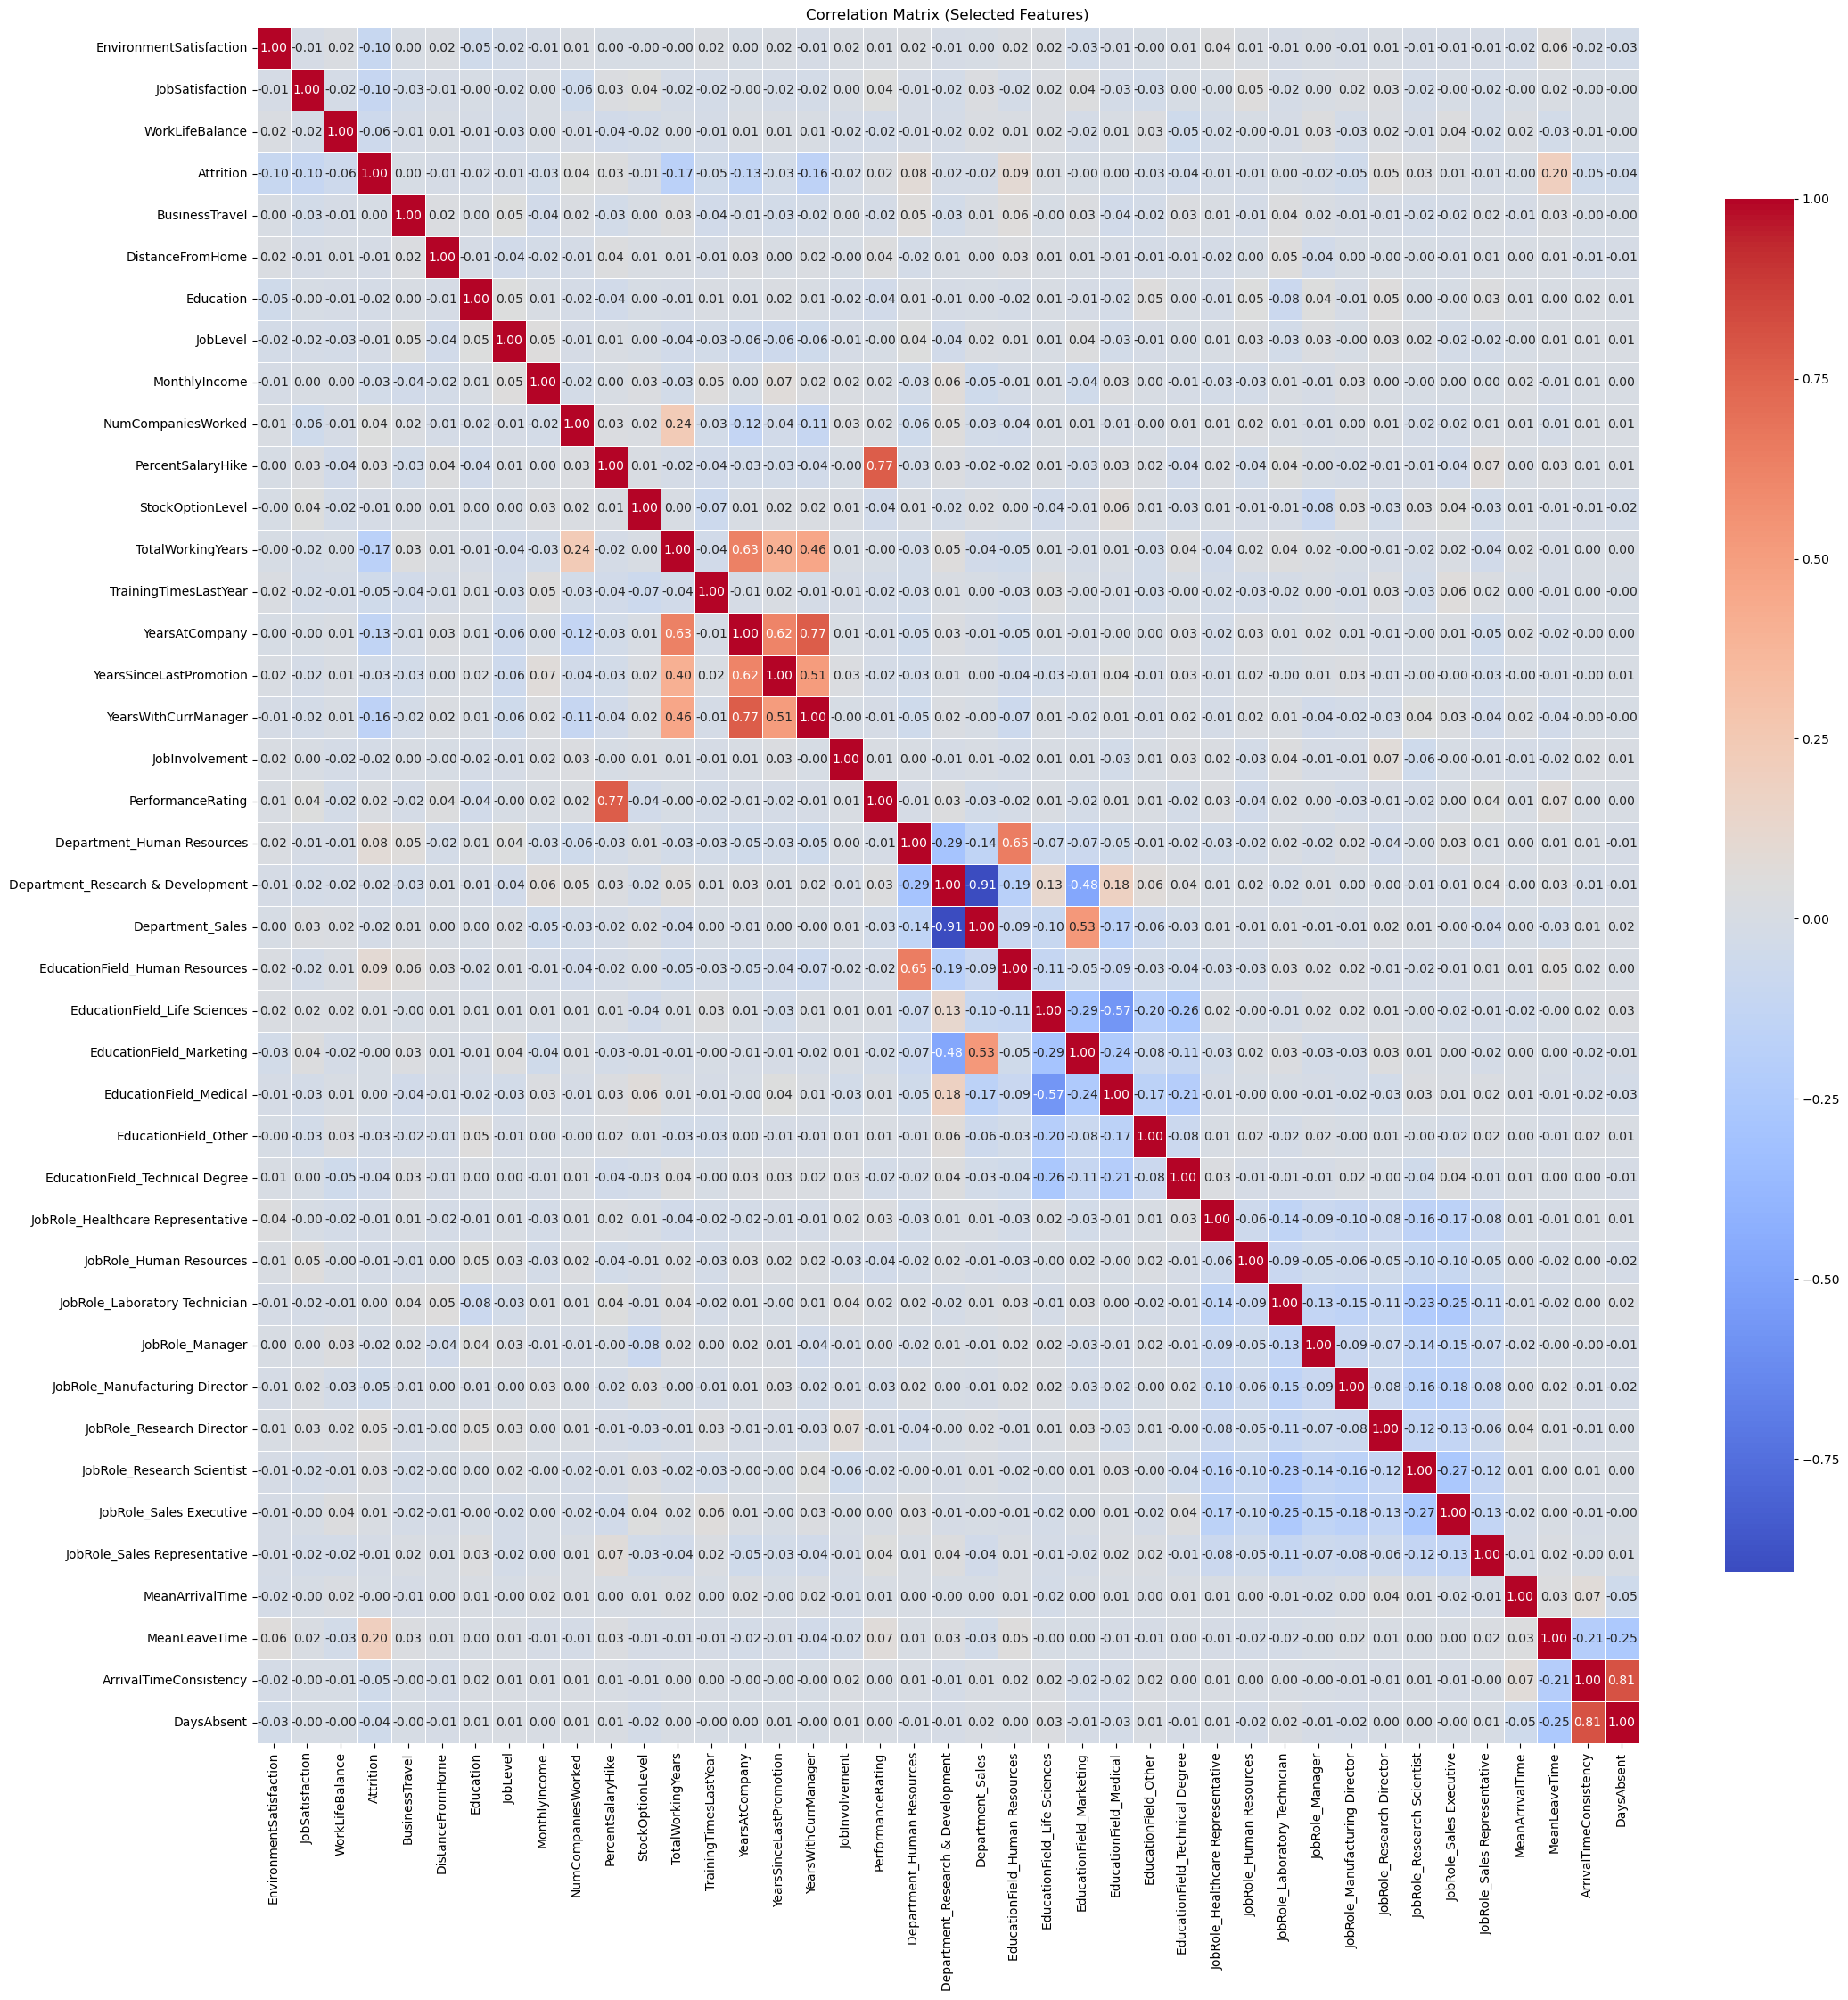

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = data.corr()

plt.figure(figsize=(25, 25))  # Adjust the size of the plot
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Correlation Matrix (Selected Features)')
plt.show()